# Making the Most of your Colab Subscription



## Faster GPUs

With Colab Pro you have priority access to our fastest GPUs and with Pro+ even more so. For example, you may get a T4 or P100 GPU at times when most users of standard Colab receive a slower K80 GPU. You can see what GPU you've been assigned at any time by executing the following cell.

If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to Runtime > Change runtime type in the menu to enable a GPU accelerator, and then re-execute the code cell.

#Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install opendatasets on Drive

In [ ]:
# import sys

# nb_path = '/content/notebooks'
# os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0,nb_path)

# # For once and forever:
!pip install --target=$nb_path opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import **DS2OS** Cybersec Data

In [ ]:
import os
import zipfile
import urllib
import opendatasets as od
import numpy as np

CYBERSEC_URL = "https://www.kaggle.com/datasets/francoisxa/ds2ostraffictraces/download?datasetVersionNumber=2"
CYBERSEC_PATH = os.path.join("drive", "MyDrive", "datasets", "cybersec")
# CYBERSEC_URL = DOWNLOAD_ROOT + "datasets/cybersec/cybersec-DS2OS.zip"

def fetch_housing_data(cybersec_url=CYBERSEC_URL, cybersec_path=CYBERSEC_PATH):
  os.makedirs(cybersec_path, exist_ok=True)
  od.download(cybersec_url, data_dir=cybersec_path)

fetch_housing_data()

Skipping, found downloaded files in "drive/MyDrive/datasets/cybersec/ds2ostraffictraces" (use force=True to force download)


#Loading Data Using Pandas

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt


def load_cybersec_data(cybersec_path=CYBERSEC_PATH):
  csv_path = os.path.join(cybersec_path, "ds2ostraffictraces",
                          "mainSimulationAccessTraces.csv")
  return pd.read_csv(csv_path)

cybersec = load_cybersec_data()
cybersec.info()
# print(cybersec.head())
# print(cybersec.describe())
# count = 0
# for attribute_ in cybersec.columns:
#   cybersec[attribute_].hist()
#   plt.xticks(rotation=45)
#   plt.show()
#   count += 1
#   if count > 9:
#     break

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357952 entries, 0 to 357951
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sourceID                   357952 non-null  object
 1   sourceAddress              357952 non-null  object
 2   sourceType                 357952 non-null  object
 3   sourceLocation             357952 non-null  object
 4   destinationServiceAddress  357952 non-null  object
 5   destinationServiceType     357952 non-null  object
 6   destinationLocation        357952 non-null  object
 7   accessedNodeAddress        357952 non-null  object
 8   accessedNodeType           357804 non-null  object
 9   operation                  357952 non-null  object
 10  value                      355902 non-null  object
 11  timestamp                  357952 non-null  int64 
 12  normality                  357952 non-null  object
dtypes: int64(1), object(12)
memory usage: 35.5+ 

#Clean up empty fields (using Pandas)

In [ ]:
cybersec.info()
# Replace empty strings with np.nan:
cybersec['value'].replace('', pd.np.nan, inplace=True)
cybersec['accessedNodeType'].replace('', pd.np.nan, inplace=True)

# Remove empty entries from value and accessedNodeType:
cybersec = cybersec.dropna(subset=['value','accessedNodeType'], how='any') # Drop all rows having empty values
# cybersec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357952 entries, 0 to 357951
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sourceID                   357952 non-null  object
 1   sourceAddress              357952 non-null  object
 2   sourceType                 357952 non-null  object
 3   sourceLocation             357952 non-null  object
 4   destinationServiceAddress  357952 non-null  object
 5   destinationServiceType     357952 non-null  object
 6   destinationLocation        357952 non-null  object
 7   accessedNodeAddress        357952 non-null  object
 8   accessedNodeType           357804 non-null  object
 9   operation                  357952 non-null  object
 10  value                      355902 non-null  object
 11  timestamp                  357952 non-null  int64 
 12  normality                  357952 non-null  object
dtypes: int64(1), object(12)
memory usage: 35.5+ 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.


#Encoding Text into Numerics

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

text_features = ['sourceID', 'sourceAddress', 'sourceType', 'sourceLocation',
                 'destinationServiceAddress', 'destinationServiceType',
                 'destinationLocation', 'accessedNodeAddress', 
                 'accessedNodeType', 'operation', 'value']

# Encoding labels:
le = LabelEncoder()
cybersec_normality = le.fit_transform(cybersec['normality'])

# Convert it to dataframe: 
cybersec_normality = pd.DataFrame(cybersec_normality, index=cybersec.index)

# OrdinalEncoding of features:
oe_features = OrdinalEncoder()
encoded_text = oe_features.fit_transform(cybersec[text_features])

# Convert it to dataframe:
encoded_text = pd.DataFrame(encoded_text, index=cybersec.index)

# Add timestamp and normality back to the dataframe:
encoded_text['timestamp'] = cybersec['timestamp'].copy()
encoded_text['normality'] = cybersec_normality.copy()

# cybersec = encoded_text.copy()

# print(encoded_text)

#Visualize Data Using PCA first 

In [ ]:
from sklearn.decomposition import PCA

reduced_cybersec = encoded_text.drop(['normality'], axis=1)
pca = PCA(n_components=3)
reduced_cybersec = pca.fit_transform(reduced_cybersec)

reduced_cybersec = pd.DataFrame(reduced_cybersec)
reduced_cybersec[3] = encoded_text['normality'].copy()

reduced_cybersec = reduced_cybersec[reduced_cybersec[3] != 7]

reduced_cybersec.head()

# reduced_cybersec.plot(kind='scatter', x=0, y=1,
#                       alpha=0.4, label='Attack', figsize=(10,7), c=2,
#                       cmap=plt.get_cmap("jet"))

# plt.legend()

# sns.set(style='darkgrid')
# fig = plt.figure(figsize=(10,10))
# ax = Axes3D(fig)
# fig.add_axes(ax)

# cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# x = reduced_cybersec[:,0]
# y = reduced_cybersec[:,1]
# z = encoded_text['normality'].copy()

# ax.view_init(5, 30)
# sc = ax.scatter(x, y, z, s=50, c=z, marker='o', cmap=cmap, alpha=0.8)

# plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# ax.set_xlim()
# ax.set_xlabel('Reduced Features X')
# ax.set_ylabel('Reduced Features Y')
# ax.set_zlabel('Normality')

# plt.show()


# !dir
reduced_cybersec.to_csv('PCA_array.csv')



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


#Perform Stratified Random Sampling of the Data

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_index, test_index in split.split(encoded_text, 
                                           encoded_text['normality']):
  strat_train_set = encoded_text.iloc[train_index] 
  strat_test_set = encoded_text.iloc[test_index]

print('Frequency of each category in the test data:\n{}'.format(
    strat_test_set['normality'].value_counts()/len(strat_test_set)))
print('\nFrequency of each category in the original data:\n{}'.format(
    encoded_text['normality'].value_counts()/len(encoded_text)))

strat_train_set.describe()

Frequency of each category in the test data:
7    0.977592
0    0.011239
4    0.004299
2    0.002501
3    0.001854
5    0.001503
1    0.000674
6    0.000337
Name: normality, dtype: float64

Frequency of each category in the original data:
7    0.977598
0    0.011239
4    0.004302
2    0.002498
3    0.001846
5    0.001495
1    0.000680
6    0.000343
Name: normality, dtype: float64


,0,1,2,3,4,5,6,7,8,9,10,timestamp,normality
count,284721.000000,284721.000000,284721.000000,284721.000000,284721.000000,284721.000000,284721.000000,284721.000000,284721.000000,284721.000000,284721.000000,2.847210e+05,284721.000000
mean,38.189140,45.141728,2.741013,8.610598,41.995582,2.268389,8.688797,84.346149,3.475174,0.920610,5167.554272,1.520078e+12,6.881140
std,29.975368,27.787235,2.207749,5.512263,26.584197,1.766587,5.271983,52.684194,2.894956,1.383379,4482.005098,2.473651e+07,0.835516
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.520032e+12,0.000000
25%,15.000000,16.000000,2.000000,5.000000,15.000000,0.000000,5.000000,31.000000,0.000000,0.000000,2.000000,1.520056e+12,7.000000
50%,29.000000,45.000000,2.000000,8.000000,42.000000,3.000000,7.000000,84.000000,3.000000,0.000000,5187.000000,1.520080e+12,7.000000
75%,71.000000,73.000000,4.000000,12.000000,71.000000,4.000000,12.000000,140.000000,7.000000,3.000000,10594.000000,1.520099e+12,7.000000
max,83.000000,88.000000,7.000000,20.000000,83.000000,7.000000,20.000000,166.000000,10.000000,3.000000,10622.000000,1.520118e+12,7.000000


#Split Features from Labels

In [ ]:
cybersec_training_features = strat_train_set.drop('normality', axis=1)
cybersec_training_labels = strat_train_set['normality'].copy()

#Feature Scaling of Training Data:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# From now on, we work on the training data only:
minmax_scaler = MinMaxScaler()

strat_train_scaled = pd.DataFrame(minmax_scaler.fit_transform(
    cybersec_training_features))

cybersec_training_features = strat_train_scaled.copy()

print(cybersec_training_labels)
print(cybersec_training_features.describe())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


171561    7
255781    7
345456    7
298307    0
271103    7
         ..
335249    7
225563    7
155548    7
60749     7
306445    7
Name: normality, Length: 284721, dtype: int64
                  0              1              2              3   \
count  284721.000000  284721.000000  284721.000000  284721.000000   
mean        0.460110       0.512974       0.391573       0.430530   
std         0.361149       0.315764       0.315393       0.275613   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.180723       0.181818       0.285714       0.250000   
50%         0.349398       0.511364       0.285714       0.400000   
75%         0.855422       0.829545       0.571429       0.600000   
max         1.000000       1.000000       1.000000       1.000000   

                  4              5              6              7   \
count  284721.000000  284721.000000  284721.000000  284721.000000   
mean        0.505971       0.324056       0.434440       0.508

#Creating ML Model Objects

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# knn = KNeighborsClassifier() #untuned
# knn = KNeighborsClassifier(n_neighbors=50, leaf_size=50) #tuned

svc = SVC(kernel='poly', degree=5)

# dt = DecisionTreeClassifier()

# rf = RandomForestClassifier()

# mlp = MLPClassifier()

#Tuning Hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

# # KNN algorithm:
# knn_param_grid = [{'n_neighbors':[2, 3, 5], 
#                    'leaf_size':[5, 10, 15]}]
# knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5,
#                            scoring='neg_mean_squared_error', return_train_score=True)
# knn_grid_search.fit(cybersec_training_features, cybersec_training_labels)

# print(knn_grid_search.best_estimator_)
# print(knn_grid_search.best_params_)

# cvres = knn_grid_search.cv_results_
# # print(cvres['mean_test_score'])
# print(np.sqrt(-cvres["mean_test_score"]).min()) # = 48834.299 less than that


# # SVC algorithm:
# svc_param_grid = [{'kernel':['linear', 'poly', 'rbf'], 
#                    'degree':[2, 3, 5]}]
# svc_grid_search = GridSearchCV(svc, svc_param_grid, cv=5,
#                            scoring='neg_mean_squared_error', return_train_score=True)
# svc_grid_search.fit(cybersec_training_features, cybersec_training_labels)

# print(svc_grid_search.best_estimator_)
# print(svc_grid_search.best_params_)

# cvres = svc_grid_search.cv_results_
# # print(cvres['mean_test_score'])
# print(np.sqrt(-cvres["mean_test_score"]).min()) # = 48834.299 less than that

#Use Cross Validation to Split The Training Set

In [ ]:
from sklearn.model_selection import cross_val_score

# # for the KNN Classifier:
# scores = cross_val_score(knn, cybersec_training_features, cybersec_training_labels,
#                          scoring="neg_mean_squared_error", cv=5)

# knn_rmse_scores = np.sqrt(-scores)

# print('Scores: {}\nMean: {}\nStandard deviation: {}'.format(
#     knn_rmse_scores, knn_rmse_scores.mean(), knn_rmse_scores.std()))

# for the SVM Classifier:
scores = cross_val_score(svc, cybersec_training_features, cybersec_training_labels,
                         scoring="neg_mean_squared_error", cv=5)

svc_rmse_scores = np.sqrt(-scores)

print('Scores: {}\nMean: {}\nStandard deviation: {}'.format(
    svc_rmse_scores, svc_rmse_scores.mean(), svc_rmse_scores.std()))

# # for the DT Classifier:
# scores = cross_val_score(dt, cybersec_training_features, cybersec_training_labels,
#                          scoring="neg_mean_squared_error", cv=5)

# dt_rmse_scores = np.sqrt(-scores)

# print('Scores: {}\nMean: {}\nStandard deviation: {}'.format(
#     dt_rmse_scores, dt_rmse_scores.mean(), dt_rmse_scores.std()))

# # for the RF Classifier:
# scores = cross_val_score(rf, cybersec_training_features, cybersec_training_labels,
#                          scoring="neg_mean_squared_error", cv=5)

# rf_rmse_scores = np.sqrt(-scores)

# print('Scores: {}\nMean: {}\nStandard deviation: {}'.format(
#     rf_rmse_scores, rf_rmse_scores.mean(), rf_rmse_scores.std()))

# # for the MLP Classifier:
# scores = cross_val_score(mlp, cybersec_training_features, cybersec_training_labels,
#                          scoring="neg_mean_squared_error", cv=5)

# mlp_rmse_scores = np.sqrt(-scores)

# print('Scores: {}\nMean: {}\nStandard deviation: {}'.format(
#     mlp_rmse_scores, mlp_rmse_scores.mean(), mlp_rmse_scores.std()))

NameError: ignored

#Asses the Model:

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# # Asses the KNN model:
# predictions = cross_val_predict(knn, cybersec_training_features,
#                                 cybersec_training_labels, cv=5)

# Asses the SVM model:
predictions = cross_val_predict(svc, cybersec_training_features,
                                cybersec_training_labels, cv=5)

# # Asses the DT model:
# predictions = cross_val_predict(dt, cybersec_training_features,
#                                 cybersec_training_labels, cv=5)

# # Asses the RF model:
# predictions = cross_val_predict(rf, cybersec_training_features,
#                                 cybersec_training_labels, cv=5)

# # Asses the MLP model:
# predictions = cross_val_predict(mlp, cybersec_training_features,
#                                 cybersec_training_labels, cv=5)

###Show Metrics:

[[  1614      0      0      0      0      0      0   1586]
 [     0    194      0      0      0      0      0      0]
 [     0      0    711      0      0      0      0      0]
 [     0      0      0    525      0      0      0      0]
 [     0      0      0      0   1171      0      0     54]
 [     0      0      0      0      0    425      0      0]
 [     0      0      0      0      0      0     98      0]
 [     3      0      0      0      1      1      3 278335]] 



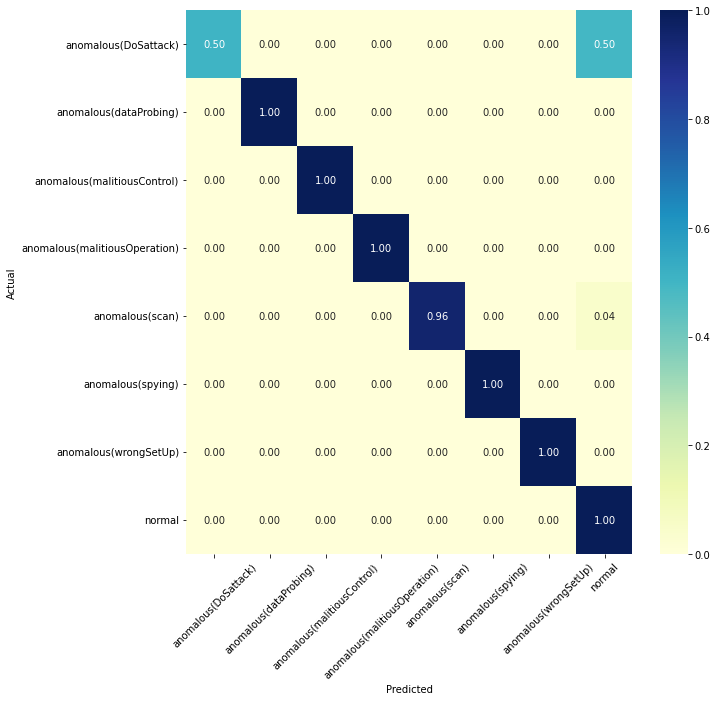


F1 Score: 0.9534973873266921
Precision: 0.9949229270136473
Recall: 0.9325330782287722
Accuracy: 0.9942118775924501


In [ ]:
# Get confusion matrix, then normalize it:
conf_matrix = confusion_matrix(cybersec_training_labels, predictions)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(cybersec_training_labels, predictions, average='macro')))
print('Precision: {}'.format(
    precision_score(cybersec_training_labels, predictions, average='macro')))
print('Recall: {}'.format(
    recall_score(cybersec_training_labels, predictions, average='macro')))
print('Accuracy: {}'.format(
    accuracy_score(cybersec_training_labels, predictions, )))

#Train the Model:

In [ ]:
# # KNN model:
# knn.fit(cybersec_training_features, cybersec_training_labels)

# SVM model:
svc.fit(cybersec_training_features, cybersec_training_labels)

# # DT model:
# dt.fit(cybersec_training_features, cybersec_training_labels)

# # RF model:
# rf.fit(cybersec_training_features, cybersec_training_labels)

# # MLP model:
# mlp.fit(cybersec_training_features, cybersec_training_labels)

SVC(degree=5, kernel='poly')

#Test Our Model:

###Split Labels and Scale Features Accordingly

In [ ]:
# Split labels from features:

cybersec_testing_features = strat_test_set.drop('normality', axis=1)
cybersec_testing_labels = strat_test_set['normality'].copy()

# Adjust column headers:
cybersec_testing_features.columns = range(cybersec_testing_features.shape[1])

minmax_scaler = MinMaxScaler()

# Scale features:
strat_test_scaled = pd.DataFrame(minmax_scaler.fit_transform(
    cybersec_testing_features))

cybersec_testing_features = strat_test_scaled.copy()

print(cybersec_testing_features.describe())
print(cybersec_testing_labels)

                 0             1             2             3             4   \
count  71181.000000  71181.000000  71181.000000  71181.000000  71181.000000   
mean       0.463422      0.512982      0.393391      0.429723      0.512198   
std        0.360629      0.315856      0.314257      0.275850      0.323966   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.180723      0.181818      0.285714      0.250000      0.182927   
50%        0.349398      0.511364      0.285714      0.400000      0.512195   
75%        0.855422      0.829545      0.571429      0.600000      0.865854   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 5             6             7             8             9   \
count  71181.000000  71181.000000  71181.000000  71181.000000  71181.000000   
mean       0.380989      0.434412      0.508286      0.389595      0.312036   
std        0.294184      0.263423      0.321038    

###Evaluate Our System on the Test Set:

In [ ]:
# # for the KNN model:
# final_predictions = knn.predict(cybersec_testing_features)

# for the SVM model:
final_predictions = svc.predict(cybersec_testing_features)

# # for the dt model:
# final_predictions = dt.predict(cybersec_testing_features)

# # for the RF model:
# final_predictions = rf.predict(cybersec_testing_features)

# # for the MLP model:
# final_predictions = mlp.predict(cybersec_testing_features)

###Show Metrics:

[[    0     0     0     0     0     0     0   800]
 [    0    48     0     0     0     0     0     0]
 [    0     0   178     0     0     0     0     0]
 [    0     0     0   132     0     0     0     0]
 [    0     0     0     0   289     0     1    16]
 [    0     0     0     0     0   107     0     0]
 [    0     0     0     0     0     0    24     0]
 [   50     0     0   233    86     0     2 69215]] 



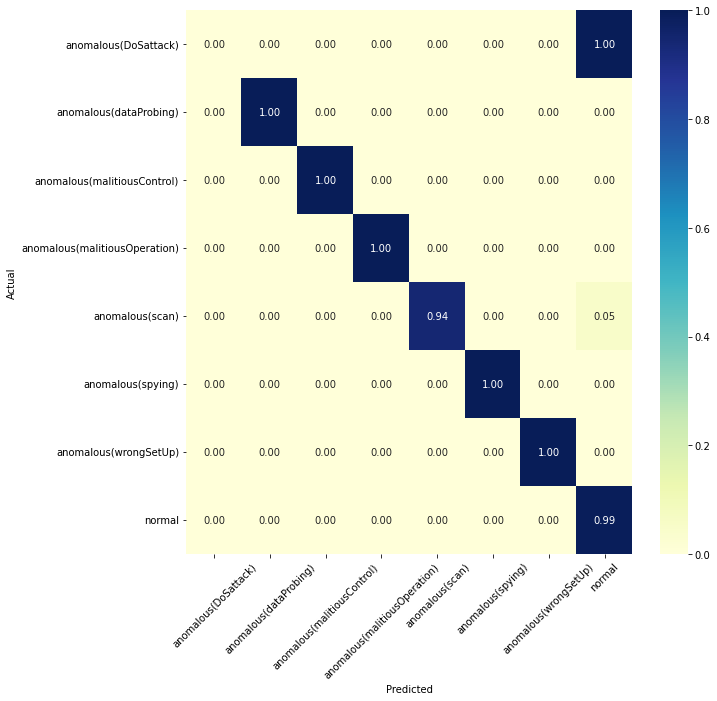


F1 Score: 0.789076699856782
Precision: 0.7511934260598269
Recall: 0.8673891140299613
Accuracy: 0.9942118775924501


In [ ]:
# Get confusion matrix, then normalize it:
conf_matrix = confusion_matrix(cybersec_testing_labels, final_predictions)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(cybersec_testing_labels, final_predictions, average='macro')))
print('Precision: {}'.format(
    precision_score(cybersec_testing_labels, final_predictions, average='macro')))
print('Recall: {}'.format(
    recall_score(cybersec_testing_labels, final_predictions, average='macro')))
print('Accuracy: {}'.format(
    accuracy_score(cybersec_training_labels, predictions, )))

# Display Features Importances

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
# print(feature_importances)
attributes = num_attrib + cat_attrib
print(sorted(zip(feature_importances, attributes), reverse=True))


###Compute 95% Confidence Interval

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - Y_test)**2
print(np.sqrt(
    stats.t.interval(confidence, len(squared_errors)-1,
                     loc=squared_errors.mean(), scale=stats.sem(squared_errors))))

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the Runtime > Change runtime type menu, and then set the hardware accelerator dropdown to GPU.

## More memory

With Colab Pro you have the option to access high-memory VMs when they are available, and with Pro+ even more so. To set your notebook preference to use a high-memory runtime, select the Runtime > 'Change runtime type' menu, and then select High-RAM in the Runtime shape dropdown.

You can see how much memory you have available at any time by running the following code cell.



If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via Runtime > Change runtime type in the menu. Then select High-RAM in the Runtime shape dropdown. After, re-execute the code cell.


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). While Colab Pro subscribers still have limits, these will be roughly twice the limits for non-subscribers, with even more stability for Pro+.

## Resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab Pro and Pro+, please avoid using resources when you don't need them. For example, only use a GPU or high-RAM runtime when required, and close Colab tabs when finished.


## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+. If you are interested in unlimited pay as you go usage to remove all imposed limits, please do let us know.

If you encounter errors or other issues with billing (payments) for Colab Pro or Pro+, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb) 
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colaboratory makes possible, check out these  tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.
